In [1]:
run performance.py \
    --target "media/example/dubrovnik.jpg" \
    --codebook-dir media/pics/ \
    --min-scale 1 \
    --max-scale 15

ImportError: libx264.so.138: cannot open shared object file: No such file or directory

In [2]:
plt.clf()
plt.plot(scales, num_tiles)
plt.title('num tiles as function of scale')
plt.ylabel("num tiles")
plt.xlabel("scale")
plt.show()

NameError: name 'plt' is not defined

In [3]:
run mosaic.py \
    --target "media/example/beach.jpg" \
    --savepath "media/output/%s-mosaic-scale-%d.jpg" \
    --codebook-dir media/pics/ \
    --scale 13 \
    --height-aspect 4 \
    --width-aspect 3 \
    --opacity 0.4

ImportError: libx264.so.138: cannot open shared object file: No such file or directory

<Figure size 432x288 with 0 Axes>

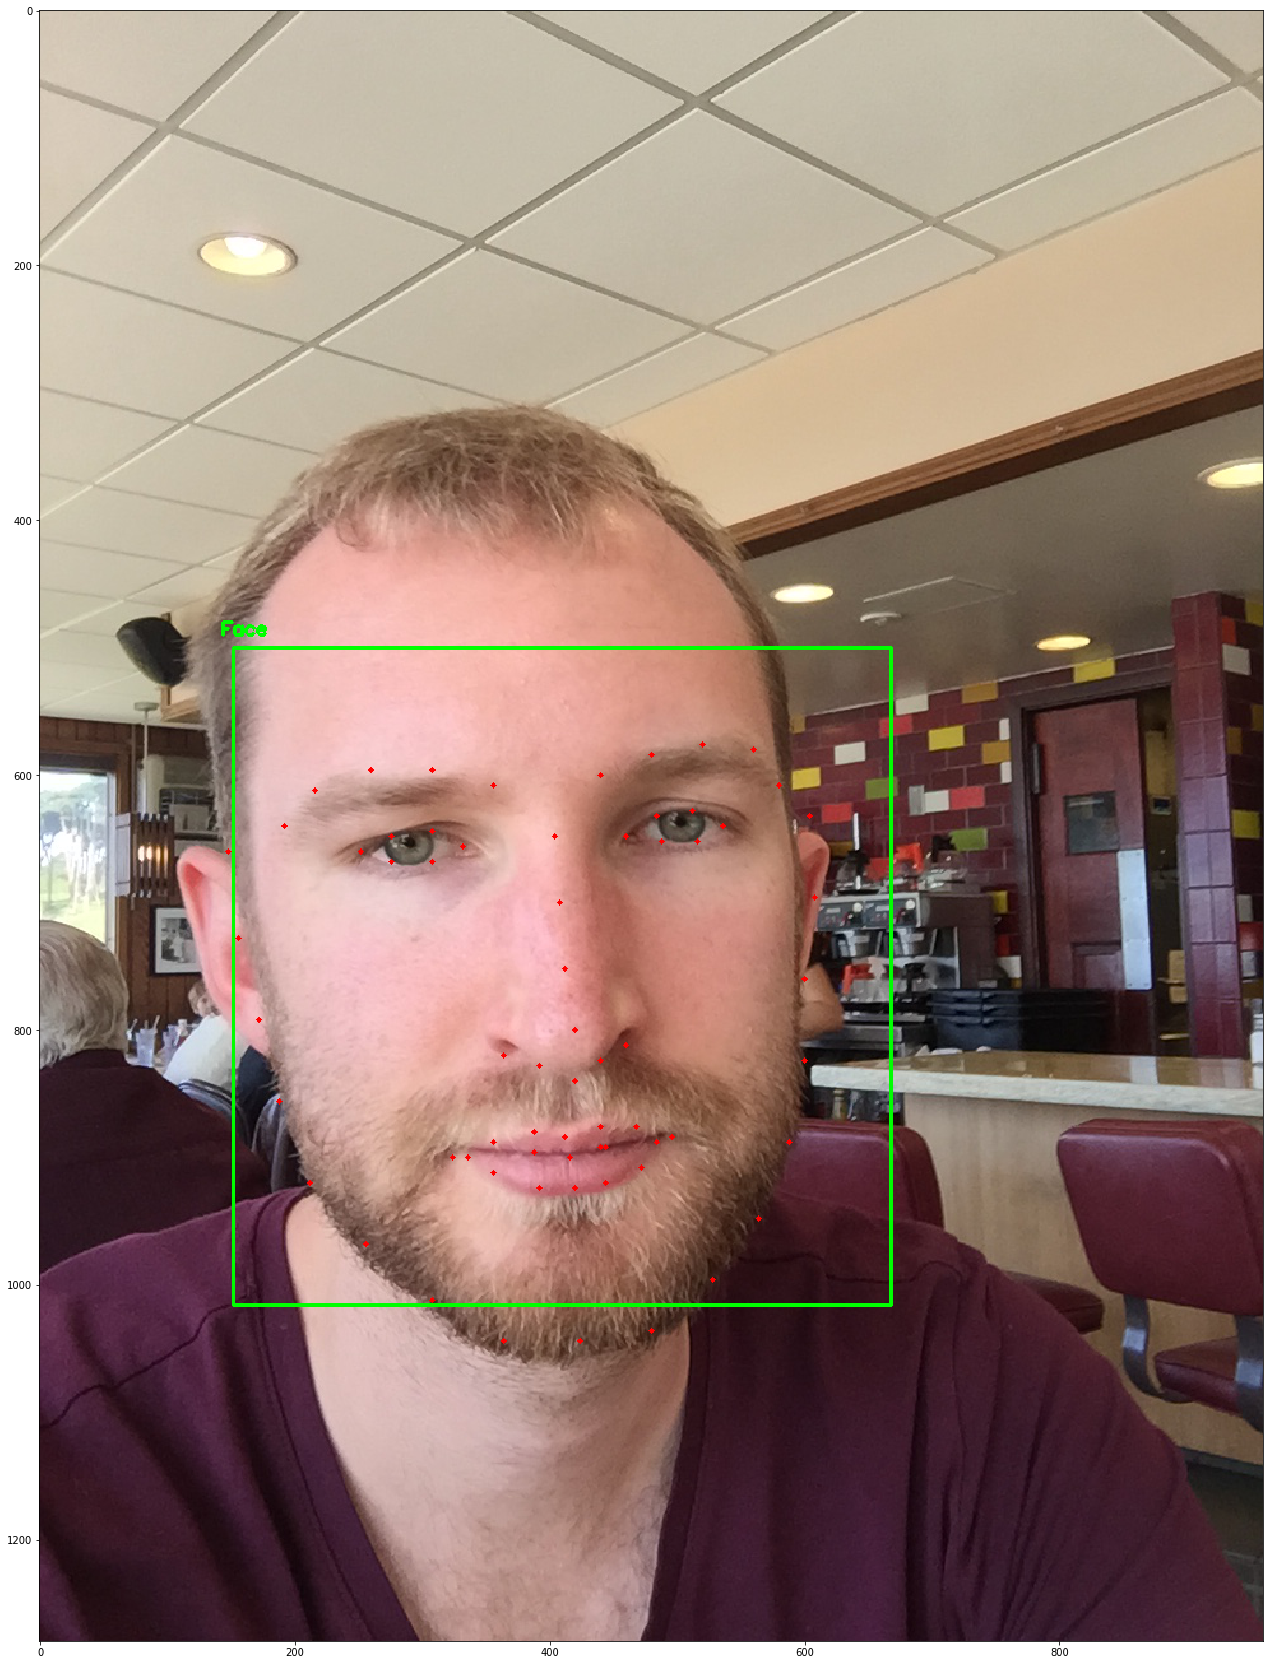

In [6]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

from emosaic.faces import detect_faces_dlib

# display
img = cv2.imread('media/pics/2016-03-24 15.11.45.jpg')
faces, perc = detect_faces_dlib(img)
for face in faces:
    img = face.mark_image(img)

plt.clf()
plt.figure(figsize = (64, 30))
plt.imshow(img[:, :, [2, 1, 0]])
plt.show()

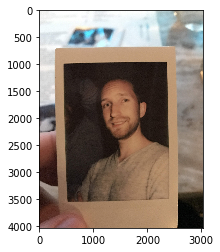

In [2]:
import cv2
import os
import glob
import dlib
import numpy as np
import matplotlib.pyplot as plt

from emosaic import faces

face_detector = dlib.get_frontal_face_detector()
keypoint_finder = dlib.shape_predictor(faces.WEIGHTS_2_PATH['landmarks_5'])
face_embedder = dlib.face_recognition_model_v1(faces.WEIGHTS_2_PATH['face_recognition'])

# plt.imshow(img[:,:,[2,1,0]])
# plt.show()

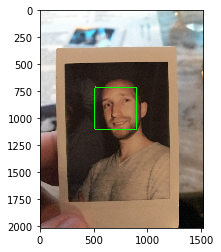

True

In [30]:
from imutils.face_utils import rect_to_bb

downsize = 0.5
face_detect_upsample_multiple = 1

# downsize
path = 'media/faces/will/2017-05-14 01.32.42.jpg'
img = cv2.imread(path)
resized = cv2.resize(img, None, fx=downsize, fy=downsize, interpolation=cv2.INTER_AREA)

# detect facial bounding boxes
rects = face_detector(resized, face_detect_upsample_multiple)
rect = rects[0]

# extract keypoints
keypoints = keypoint_finder(resized, rect)
keypoints_arr = faces.shape_to_np(keypoints)

# get coordinates
bb = rect_to_bb(rect)
(x, y, w, h) = int(bb[0]), int(bb[1]), int(bb[2]), int(bb[3])

cv2.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 3)

# show the face number
cv2.putText(resized, "Face", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 3)

# loop over the (x, y)-coordinates for the facial landmarks
# and draw them on the image
for (x, y) in keypoints_arr:
    cv2.circle(resized, (x, y), 3, (0, 0, 255), -1)
        
# show image
plt.imshow(resized[:,:,[2,1,0]])
plt.show()

cv2.imwrite('test.jpg', resized)

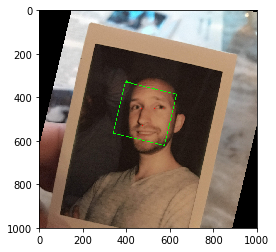

In [114]:

from imutils.face_utils.helpers import FACIAL_LANDMARKS_5_IDXS, FACIAL_LANDMARKS_68_IDXS

def get_eye_measurements(dlib_keypoints):
    keypoints_arr = faces.shape_to_np(dlib_keypoints)
    
    if len(keypoints_arr) == 68:
        # extract the left and right eye (x, y)-coordinates
        (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
    else:
        (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

    # get all points that constitute each eye
    left_eye_points = keypoints_arr[ lStart : lEnd + 1]
    right_eye_points = keypoints_arr[ rStart : rEnd + 1]
    
    # compute the centroid for each eye
    left_eye_center = left_eye_points.mean(axis=0).astype("int")
    right_eye_center = right_eye_points.mean(axis=0).astype("int")
    
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2)
    
    # compute the angle between the eye centroids
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
    
    # get distance between eyes
    eye_distance = np.sqrt((dX ** 2) + (dY ** 2))

    return eyes_center, left_eye_center, right_eye_center, dX, dY, angle, eye_distance

def generate_aligned_face(
        img,
        dlib_face_rect,
        dlib_keypoints,
        desired_left_eye_percs=(0.45, 0.45), 
        desired_face_size=1000
    ):
    """
    Based on:
    https://github.com/jrosebr1/imutils/blob/master/imutils/face_utils/facealigner.py
    """
    # get eye measurements
    eyes_center, left_eye_center, right_eye_center, dX, dY, angle, eye_distance = \
        get_eye_measurements(dlib_keypoints)
    
    # calculate percentage for right eye
    desired_right_eye_x_perc = 1.0 - desired_left_eye_percs[0]
    
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    desired_dist = (desired_right_eye_x_perc - desired_left_eye_percs[0]) * desired_face_size
    scale = desired_dist / eye_distance

    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    
    # update the translation component of the matrix
    tX = desired_face_size * 0.5
    tY = desired_face_size * desired_left_eye_percs[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])
    
    # apply the affine transformation
    (w, h) = (desired_face_size, desired_face_size)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC) 

output = generate_aligned_face(
        resized,
        dlib_face_rect=rect,
        dlib_keypoints=keypoints,
        desired_left_eye_percs=(0.45, 0.45), 
        desired_face_size=1000
    )

plt.imshow(output[:,:,[2,1,0]])
plt.show()